# DS-SF-23 | Hafsa Vahidy

### Unit Project 2

In this project, you will implement the exploratory analysis plan developed in Unit Project 1.  This will lay the groundwork for our our first modeling exercise in Unit Project 3.

My problem statement: Using UCLA's grad school admissions data (gre, gpa, and prestige), identify the factor(s) which influenced admission (admit) into UCLA's graduate school.

### Step 1: Load the python libraries you will need for this project

In [146]:
# imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import scipy.stats as stats
%matplotlib inline

### Step 2: Read in your data set

In [147]:
# read in data from source
df_raw = pd.read_csv("../../dataset/admissions.csv")
print df_raw.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Questions
#### Question 1. How many observations are in our dataset?


In [148]:
print df_raw.count()
print len(df_raw)

admit       400
gre         398
gpa         398
prestige    399
dtype: int64
400


Answer: 400 rows of data with 4 columns. 5 values are missing from the dataset.

#### Question 2. Create a summary table.

In [261]:
df_raw.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


#### Question 3. Why would GRE have a larger STD than GPA?

Answer: The range (also the values and the mean) for GRE is larger than the range for GPA.

#### Question 4. Drop data points with missing data.


In [150]:
df_dropped = df_raw.dropna()

#### Question 5. Confirm that you dropped the correct data.  How can you tell?

In [151]:
print df_dropped.count()
print len(df_dropped)

admit       397
gre         397
gpa         397
prestige    397
dtype: int64
397


Answer: The length of df_dropped is less than the length of df_raw from above (397 vs 400). Also, the count of the non-NaN values is equivalent to the length of the entire dataframe.

#### Question 6. Create box plots for GRE and GPA.

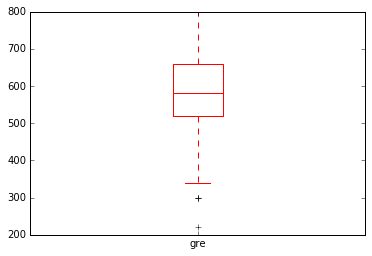

In [152]:
# GRE boxplot 1
df_dropped.gre.plot(kind='box', color='r')

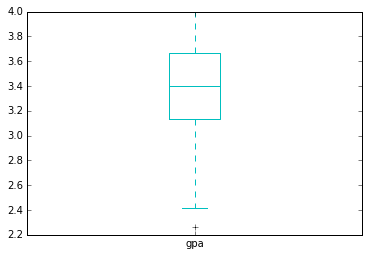

In [153]:
# GPA boxplot 2
df_dropped.gpa.plot(kind='box', color='c')

#### Question 7. What do these plots show?

Answer: These plots show the median, interquartile range, and overall range for GRE and GPA respectively. GRE scores seem to be evenly distributed between the quartiles. GPA scores appear to have more values in a smaller, higher range.

count    397.000000
mean     587.858942
std      115.717787
min      220.000000
25%      520.000000
50%      580.000000
75%      660.000000
max      800.000000
Name: gre, dtype: float64
-0.146046988216


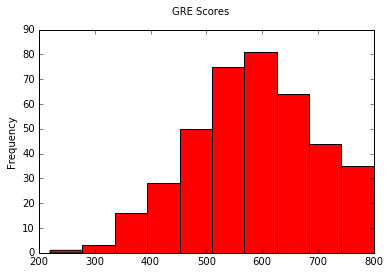

In [254]:
# Plot the distribution of each variable
df_dropped.gre.plot(kind='hist', color='r')
pl.suptitle("GRE Scores")
print df_dropped.gre.describe()
print df_dropped['gre'].skew()

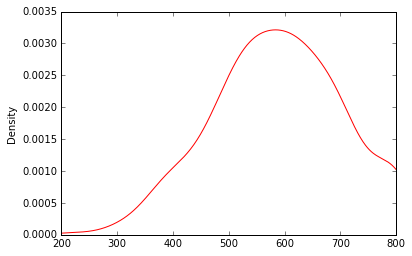

In [260]:
df_dropped.gre.plot(kind='density', color='r', xlim=(200,800))

Text(0.5,0.98,u'GPA Scores')
count    397.000000
mean       3.392242
std        0.380208
min        2.260000
25%        3.130000
50%        3.400000
75%        3.670000
max        4.000000
Name: gpa, dtype: float64
-0.216888932969


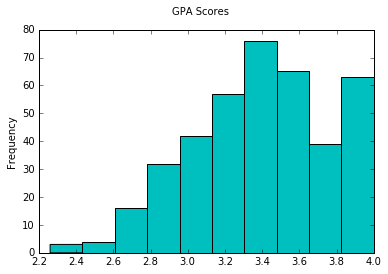

In [249]:
df_dropped.gpa.plot(kind='hist', color='c')
print pl.suptitle("GPA Scores")
print df_dropped.gpa.describe()
print df_dropped['gpa'].skew()

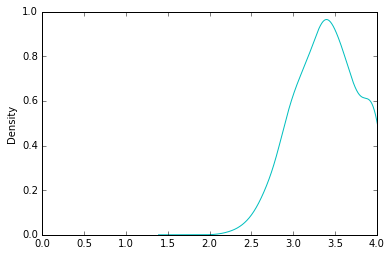

In [257]:
df_dropped.gpa.plot(kind='density', color='c', xlim=(0,4.0))

0.086505552897055041

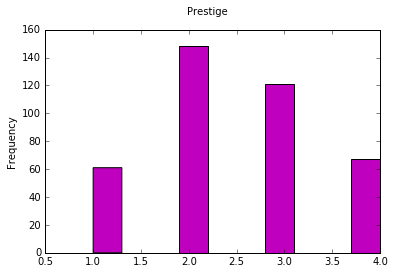

In [251]:
df_dropped.prestige.plot(kind='hist', color='m')
pl.suptitle("Prestige")
df_dropped['prestige'].skew()

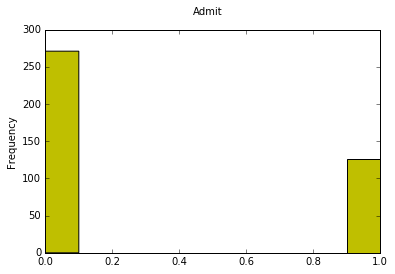

In [252]:
df_dropped.admit.plot(kind='hist', color='y')
pl.suptitle("Admit")

GRE:
The data has a slight left skew and is unimodal.

GPA:
The data has a slight left skew and isn't quite unimodal.

Prestige:
The data has a normal distribution and is unimodal.

#### Question 9. If our model had an assumption of a normal distribution would we meet that requirement?

In [212]:
# Normal distribution test (p-value)
print stats.normaltest(df_dropped.gre)
print stats.normaltest(df_dropped.gpa)

NormaltestResult(statistic=3.8179829306094266, pvalue=0.14822980613776662)
NormaltestResult(statistic=13.079875560916445, pvalue=0.001444578377229117)


In [159]:
print stats.chisquare(df_dropped.prestige)
#print stats.chi2_contingency(df_dropped.prestige)

Power_divergenceResult(statistic=142.72672064777325, pvalue=1.0)


Answer: No, as seen in the histograms, two of our variables show a clear left skew. After running a t-test, the p-value for GPA (.0014) is < 0.05, which suggests not normal, and the value for GRE (.1482) is > 0.05 which suggests normal. Since Prestige is categorical, I ran a chi-square test and p = 1.

#### Question 10. Does this distribution need correction?  If so, why?  How?

NormaltestResult(statistic=14.387731469612829, pvalue=0.00075117963919810985)

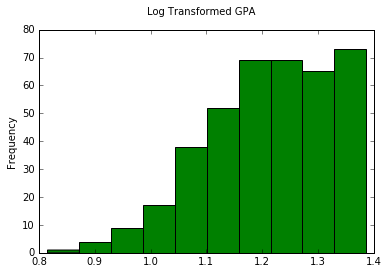

In [193]:
# Try a log transformation for GPA
df_gpa_log = np.log(df_dropped.gpa)
df_gpa_log.plot(kind='hist', color='g')
pl.suptitle("Log Transformed GPA")
stats.normaltest(df_gpa_log)

NormaltestResult(statistic=13.079875560916445, pvalue=0.001444578377229117)

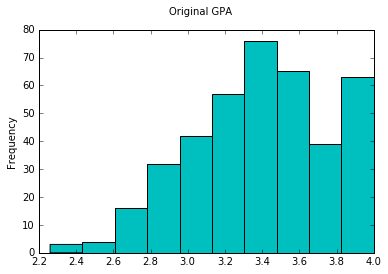

In [195]:
df_dropped.gpa.plot(kind='hist', color='c')
pl.suptitle("Original GPA")
stats.normaltest(df_dropped.gpa)

Answer: The data needs correction in regards to the GPA scores. Even after log transforming, the data is no where nearer to normal distribution as the p-value is even smaller. The log transformed data is useless and unnecessary. Now I will identify the outliers to correct the GPA dataset.

In [196]:
# Identify outliers for the data set
df_outliers = df_dropped[df_dropped.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

NormaltestResult(statistic=3.8179829306094266, pvalue=0.14822980613776662)

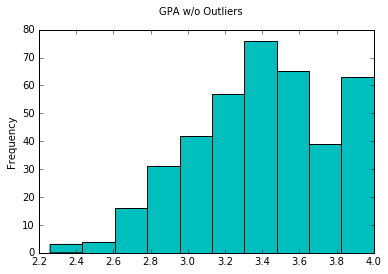

In [216]:
# Plot the new GPA dataset sans outliers
df_outliers.gpa.plot(kind='hist', color='c')
pl.suptitle("GPA w/o Outliers")
stats.normaltest(df_dropped.gre)

The GPA dataset sans outliers has a sound p-value: 0.148 vs 0.001 and is > 0.05

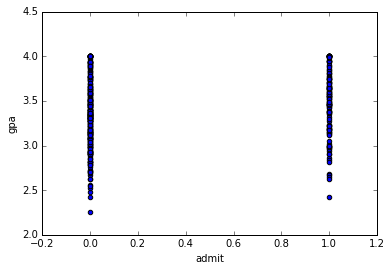

In [241]:
df_dropped.plot(kind='scatter', x='admit', y='gpa')

#### Question 11. Which of our variables are potentially colinear?

               gre       gpa  prestige
gre       1.000000  0.376383 -0.121800
gpa       0.376383  1.000000 -0.059141
prestige -0.121800 -0.059141  1.000000
Axes(0.125,0.125;0.775x0.775)


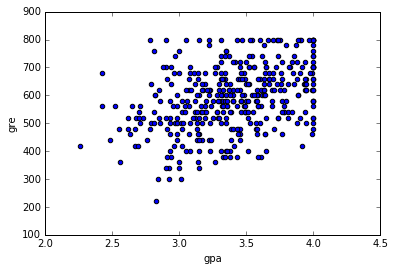

In [264]:
# Create a correlation matrix for the data
print df_outliers.drop('admit', axis=1).corr(method='pearson', min_periods=1)
print df_dropped.plot(kind='scatter', x='gpa', y='gre')
#df_raw.corr(method='kendall', min_periods=1)
#df_raw.corr(method='spearman', min_periods=1)

#### Question 12. What did you find?

Answer: Using the scatterplot pattern, GPA and GRE are potentially collinear.

#### Question 13. Write an analysis plan for exploring the association between grad school admissions rates and prestige of undergraduate schools.

Answer: Compare the relationship between the two categorical variables, prestige and admission status, specifically via scatter plots and contingency tables.

#### Question 14. What is your hypothesis?

Answer: I hypothesize that there will be a slightly positive but no significant association between prestige and admission status.

## Bonus/Advanced

#### 1. Bonus: Explore alternatives to dropping obervations with missing data.

#### 2. Bonus: Log transform the skewed data.

#### 3. Advanced: Impute missing data.